In [187]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt, pathlib, requests, tqdm, ssl, certifi
from PIL import Image
from io import BytesIO
import os
from rembg import remove
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [ ]:
DEVICE          = "cpu"
CHECKPOINT_NAME = "sam_vit_b_01ec64.pth"
CHECKPOINT_URL  = f"https://dl.fbaipublicfiles.com/segment_anything/{CHECKPOINT_NAME}"
IMG_NAME        = "2.9.jpg"
IMG_PATH        = f"OUTFITS/{IMG_NAME}"

In [189]:
# ==============================================
# 2)  ดาวน์โหลด Checkpoint หากยังไม่มี
#     (ใช้ requests + certifi ตัดปัญหา SSL)
# ==============================================
weights = pathlib.Path("models") / CHECKPOINT_NAME
weights.parent.mkdir(exist_ok=True)

if not weights.exists():
    with requests.get(CHECKPOINT_URL, stream=True, timeout=60) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        with open(weights, "wb") as f, tqdm.tqdm(total=total, unit="B", unit_scale=True,
                                                 desc=CHECKPOINT_NAME) as pbar:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))

(-0.5, 649.5, 620.5, -0.5)

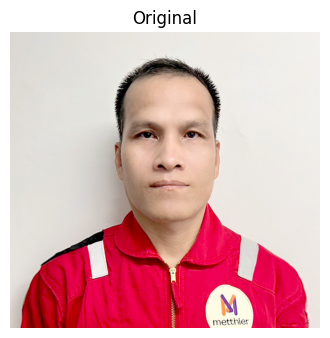

In [190]:
# ==============================================
# 3)  โหลดภาพต้นฉบับ  (BGR → RGB)
# ==============================================
bgr   = cv2.imread(IMG_PATH)
if bgr is None:
    raise FileNotFoundError(f"Could not read {IMG_PATH}")
rgb   = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4)); plt.imshow(rgb); plt.title("Original"); plt.axis("off")

2025-06-27 17:13:14.464184 [W:onnxruntime:, coreml_execution_provider.cc:113 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300
Context leak detected, CoreAnalytics returned false
Context leak detected, CoreAnalytics returned false


(-0.5, 649.5, 620.5, -0.5)

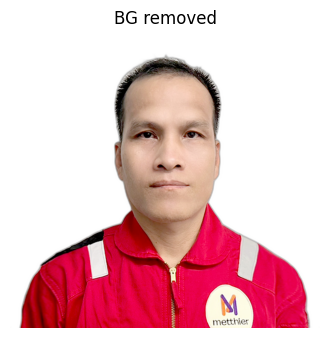

In [191]:
# ==============================================
# 3a)  🔥 Background Removal ก่อนเข้า SAM
# ==============================================
img_pil = Image.fromarray(rgb).convert("RGBA")
removed = remove(img_pil)                    # อาจคืนเป็น bytes หรือ PIL.Image
if isinstance(removed, bytes):
    removed = Image.open(BytesIO(removed)).convert("RGBA")

# สำหรับ SAM → ต้อง 3-channel  จึงรวม background โปร่งใสกับสีขาว
rgba        = np.array(removed)
alpha_mask  = rgba[..., 3:] / 255.0
rgb_nobg    = (rgba[..., :3] * alpha_mask + (1 - alpha_mask) * 255).astype(np.uint8)

plt.figure(figsize=(4,4)); plt.imshow(rgb_nobg); plt.title("BG removed"); plt.axis("off")


In [192]:
# ==============================================
# 4)  โหลด SAM
# ==============================================
sam = sam_model_registry["vit_b"](checkpoint=str(weights))
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


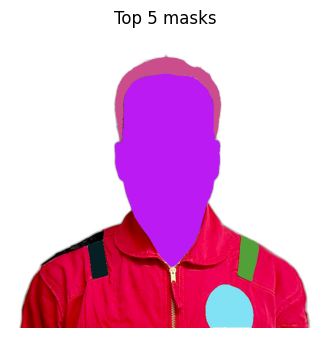

In [193]:
# ==============================================
# 5)  Automatic masks (optional สำรวจ) บนภาพไม่มี BG
# ==============================================
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side       = 32,
    min_mask_region_area  = 512,
)
auto_masks = mask_generator.generate(rgb_nobg)

def show_masks(src, masks, n_show=5):
    overlay = src.copy()
    for m in masks[:n_show]:
        color = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
        overlay[m["segmentation"]] = color
    plt.figure(figsize=(4,4)); plt.imshow(overlay); plt.axis("off"); plt.title(f"Top {n_show} masks")

show_masks(rgb_nobg, auto_masks)

In [194]:
# ==============================================
# 6)  Box-prompted เลือกเสื้อ (ค่า bbox คร่าว ๆ)
# ==============================================
bbox_shirt = np.array([60, 240, 630, 650])   # ← ปรับตามภาพ

predictor = SamPredictor(sam)
predictor.set_image(rgb_nobg)                # ← ใช้ภาพไม่มี BG
masks, scores, _ = predictor.predict(
    box=bbox_shirt[None, :],
    multimask_output=True
)
shirt_mask = masks[np.argmax(masks.reshape(masks.shape[0], -1).sum(axis=1))]


masks.shape = (3, 621, 650)
scores = [0.9804208  0.96272236 0.6392634 ]
✔️ Saved mask 0 → result/2.8.jpg_mask_0.png
✔️ Saved mask 1 → result/2.8.jpg_mask_1.png


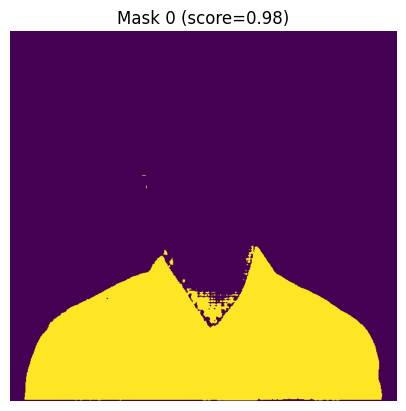

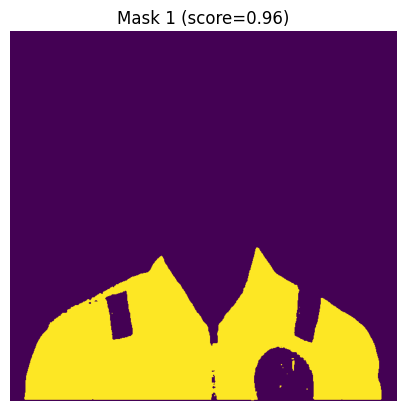

In [195]:
# ...existing code...
print("masks.shape =", masks.shape)        # ดูขนาด (N, H, W)
print("scores =", scores)                  # คะแนนแต่ละ mask
# แสดงภาพ mask ทั้งหมด
for i, mask in enumerate(masks):
    plt.figure(); 
    plt.imshow(mask); 
    plt.title(f"Mask {i} (score={scores[i]:.2f})"); 
    plt.axis("off");
    # Save each mask as an image
    os.makedirs("result", exist_ok=True)
    out_path = f"result/{IMG_NAME}_mask_{i}.png"
    mask_img = (mask.astype(np.uint8) * 255)  # Convert to 0-255 range
    cv2.imwrite(out_path, mask_img)
    print(f"✔️ Saved mask {i} → {out_path}")
    if i == 1:
        break    
# ...existing code...

✔️  Saved → image_without_shirt.png


Text(0.5, 1.0, 'Shirt removed')

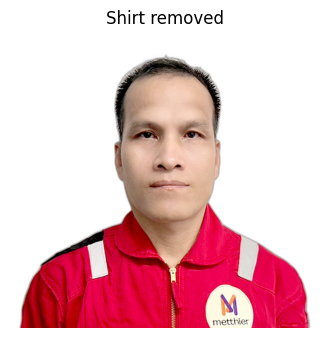

In [196]:
# ==============================================
# 7)  ทำ Alpha ให้เสื้อโปร่งใส
# ==============================================
alpha_full  = (1 - shirt_mask.astype(np.uint8)) * 255  # เสื้อ = 0
rgba_result = np.dstack([rgb_nobg, alpha_full.astype(np.uint8)])
out_path    = "image_without_shirt.png"
cv2.imwrite(out_path, cv2.cvtColor(rgba_result, cv2.COLOR_RGBA2BGRA))
print("✔️  Saved →", out_path)

plt.figure(figsize=(4,4)); plt.imshow(cv2.cvtColor(rgba_result, cv2.COLOR_RGBA2RGB))
plt.axis("off"); plt.title("Shirt removed")


In [197]:
# ----------------------------------------------
# A1)  ขยาย mask ให้กินขอบเพิ่ม  (5–10 px)
# ----------------------------------------------
# shirt_mask คือ bool/uint8 2D จากขั้น SAM
kernel      = np.ones((7,7), np.uint8)   # ปรับขนาดได้
mask_big    = cv2.dilate(shirt_mask.astype(np.uint8), kernel, iterations=2)

# (ถ้า mask โป่งไปถึงคอ ใช้ erode เบา ๆ คืนทีหลัง)
# mask_big  = cv2.erode(mask_big, kernel, iterations=1)

# ----------------------------------------------
# A2)  ทำอัลฟาทับซ้อนใหม่
# ----------------------------------------------
alpha_full  = (1 - mask_big) * 255          # เสื้อทั้งหมด = 0
rgba_clean  = np.dstack([rgb_nobg, alpha_full.astype(np.uint8)])

cv2.imwrite("image_without_shirt.png",
            cv2.cvtColor(rgba_clean, cv2.COLOR_RGBA2BGRA))
# print("✔️  Saved → image_without_shirt.png")


True

2025-06-27 17:14:59.682355 [W:onnxruntime:, coreml_execution_provider.cc:113 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300
Context leak detected, CoreAnalytics returned false
Context leak detected, CoreAnalytics returned false


✔️  Saved → /Users/nonthpawit.soo/Desktop/WebChangeOutfits/image_cut_background.png


Text(0.5, 1.0, 'Head & Neck only (final)')

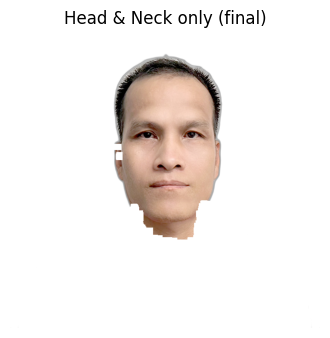

In [198]:
# ==============================================
# 8)  (ต่อไปตามเดิม) rembg เอาพื้นหลังของหัว/คอออกทั้งหมด
# ==============================================
from io import BytesIO
input_path   = pathlib.Path(out_path)
output_path  = pathlib.Path("image_cut_background.png")

headneck_img = Image.open(input_path).convert("RGBA")
bg_removed   = remove(headneck_img)
if isinstance(bg_removed, bytes):
    bg_removed = Image.open(BytesIO(bg_removed)).convert("RGBA")

bg_removed.save(output_path)
print("✔️  Saved →", output_path.resolve())

plt.figure(figsize=(4,4)); plt.imshow(bg_removed); plt.axis("off"); plt.title("Head & Neck only (final)")
